In [1]:
# utilities
import re
import pickle
import numpy as np
import pandas as pd

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [2]:
df = pd.read_csv("/kaggle/input/twtanalisis/merged_dataset.csv")


df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2124 entries, 0 to 2123
Data columns (total 1 columns):
full_text    2124 non-null object
dtypes: object(1)
memory usage: 16.7+ KB


In [3]:
df.rename(columns={"full_text": "text"}, inplace=True)

In [4]:
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

In [5]:
def preprocess(textdata, stopwords_id, emojis):
    processedText = []

    wordLemm = WordNetLemmatizer()

    urlPattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern = '@[^\s]+'
    alphaPattern = "[^a-zA-Z0-9]"
    sequencePattern = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"

    for tweet in textdata:
        tweet = tweet.lower()

        tweet = re.sub(urlPattern, ' ', tweet)
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "" + emojis[emoji])
        tweet = re.sub(userPattern, '', tweet)
        tweet = re.sub(alphaPattern, " ", tweet)
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            if word not in stopwords_id:
                if len(word) > 1:
                    word = wordLemm.lemmatize(word)
                    tweetwords += (word + ' ')

        processedText.append(tweetwords)

    return processedText

def tokenizingText(
    text,
):  # Tokenizing or splitting a string, text into a list of tokens
    text = word_tokenize(text)
    return text


def filteringText(text):  # Remove stopwors in a text
    listStopwords = set(stopwords.words("indonesian"))
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text


def toSentence(list_words):  # Convert list of words into sentence
    sentence = " ".join(word for word in list_words)
    return sentence

In [6]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

nltk_stw_id = stopwords.words('indonesian')

# # Preprocessing df data

df['text_clean'] = preprocess(df['text'], nltk_stw_id, emojis)

df["text_preprocessed"] = df["text_clean"].apply(tokenizingText)
df["text_preprocessed"] = df["text_preprocessed"].apply(filteringText)

df.drop(["text"], axis=1, inplace=True)

df.head()

# df.to_csv('covid_preprocessing.csv', index = False, header = True,index_label=None)

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,text_clean,text_preprocessed
0,kaleidoskop 2022 gebrakan padat karya destinas...,"[kaleidoskop, 2022, gebrakan, padat, karya, de..."
1,repost halo kawanlaut pelabuhan tanjung perak ...,"[repost, halo, kawanlaut, pelabuhan, tanjung, ..."
2,kabupaten kota covid 19 tertinggi jawa timur k...,"[kabupaten, kota, covid, 19, tertinggi, jawa, ..."
3,angka covid 19 kabupaten malang meninggi uruta...,"[angka, covid, 19, kabupaten, malang, meninggi..."
4,pemerintah kota surabaya berupaya menggenjot c...,"[pemerintah, kota, surabaya, berupaya, menggen..."


In [7]:
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2124 entries, 0 to 2123
Data columns (total 2 columns):
text_clean           2124 non-null object
text_preprocessed    2124 non-null object
dtypes: object(2)
memory usage: 33.3+ KB


In [8]:
def preprocess_text(text):
    if pd.isna(text).any():
        return []
    text = str(text)
    cleaned_text = (
        text.replace("'", "").replace(",", "").replace("]", "").replace("[", "")
    )
    words_list = cleaned_text.split()
    return words_list


df["text_preprocessed"] = df["text_preprocessed"].apply(preprocess_text)

In [9]:
import csv

lexicon_positive = dict()
with open("/kaggle/input/lexicon/positive.tsv", "r") as csvfile:
    reader = csv.reader(csvfile, delimiter="\t")  # Corrected delimiter to tab
    header = next(reader, None)
    for row in reader:
        lexicon_positive[row[0]] = int(row[1])

lexicon_negative = dict()
with open("/kaggle/input/lexicon/negative.tsv", "r") as csvfile:
    reader = csv.reader(csvfile, delimiter="\t")  # Corrected delimiter to tab
    header = next(reader, None)
    for row in reader:
        lexicon_negative[row[0]] = int(row[1])


# Function to determine sentiment polarity of df
def sentiment_analysis_lexicon_indonesia(text):
    # for word in text:
    score = 0
    for word in text:
        if word in lexicon_positive:
            score = score + lexicon_positive[word]
    for word in text:
        if word in lexicon_negative:
            score = score + lexicon_negative[word]
    polarity = ""
    if score > 0:
        polarity = "positive"
    elif score < 0:
        polarity = "negative"
    else:
        polarity = "neutral"
    return score, polarity

In [10]:
results = df["text_preprocessed"].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
df["polarity_score"] = results[0]
df["polarity"] = results[1]
print(df["polarity"].value_counts())

neutral     1105
negative     667
positive     352
Name: polarity, dtype: int64


In [11]:
df.head()

,text_clean,text_preprocessed,polarity_score,polarity
0,kaleidoskop 2022 gebrakan padat karya destinas...,"[kaleidoskop, 2022, gebrakan, padat, karya, de...",-7,negative
1,repost halo kawanlaut pelabuhan tanjung perak ...,"[repost, halo, kawanlaut, pelabuhan, tanjung, ...",-15,negative
2,kabupaten kota covid 19 tertinggi jawa timur k...,"[kabupaten, kota, covid, 19, tertinggi, jawa, ...",-9,negative
3,angka covid 19 kabupaten malang meninggi uruta...,"[angka, covid, 19, kabupaten, malang, meninggi...",-11,negative
4,pemerintah kota surabaya berupaya menggenjot c...,"[pemerintah, kota, surabaya, berupaya, menggen...",10,positive


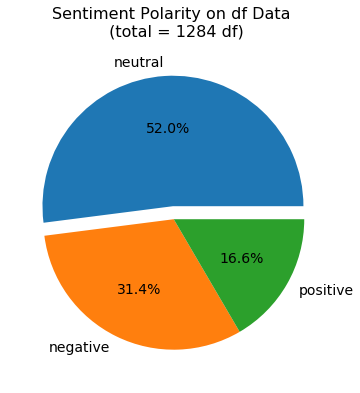

In [12]:
fig, ax = plt.subplots(figsize=(6, 6))
sizes = [count for count in df["polarity"].value_counts()]
labels = list(df["polarity"].value_counts().index)
explode = (0.1, 0, 0)
ax.pie(
    x=sizes,
    labels=labels,
    autopct="%1.1f%%",
    explode=explode,
    textprops={"fontsize": 14},
)
ax.set_title("Sentiment Polarity on df Data \n (total = 1284 df)", fontsize=16, pad=20)
plt.show()

In [13]:
# Function to group all positive/negative words
def words_with_sentiment(text):
    positive_words = []
    negative_words = []
    for word in text:
        score_pos = 0
        score_neg = 0
        if word in lexicon_positive:
            score_pos = lexicon_positive[word]
        if word in lexicon_negative:
            score_neg = lexicon_negative[word]

        if score_pos + score_neg > 0:
            positive_words.append(word)
        elif score_pos + score_neg < 0:
            negative_words.append(word)

    return positive_words, negative_words

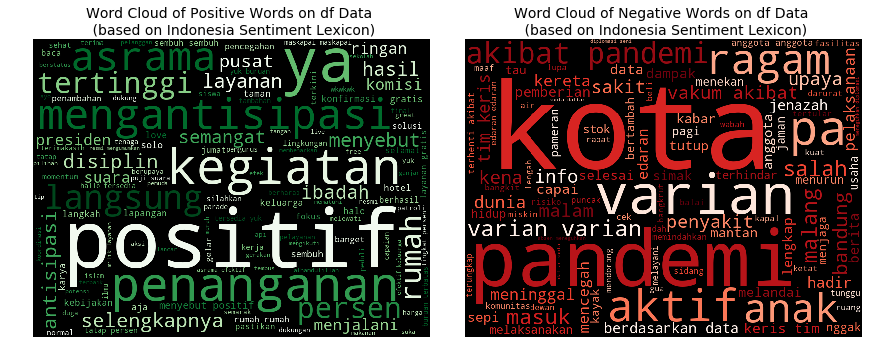

In [14]:
# Visualize positive and negative word cloud

sentiment_words = df["text_preprocessed"].apply(words_with_sentiment)
sentiment_words = list(zip(*sentiment_words))
positive_words = sentiment_words[0]
negative_words = sentiment_words[1]

fig, ax = plt.subplots(1, 2, figsize=(12, 10))
list_words_postive = ""
for row_word in positive_words:
    for word in row_word:
        list_words_postive += " " + (word)
wordcloud_positive = WordCloud(
    width=800, height=600, background_color="black", colormap="Greens", min_font_size=10
).generate(list_words_postive)
ax[0].set_title(
    "Word Cloud of Positive Words on df Data \n (based on Indonesia Sentiment Lexicon)",
    fontsize=14,
)
ax[0].grid(False)
ax[0].imshow((wordcloud_positive))
fig.tight_layout(pad=0)
ax[0].axis("off")

list_words_negative = ""
for row_word in negative_words:
    for word in row_word:
        list_words_negative += " " + (word)
wordcloud_negative = WordCloud(
    width=800, height=600, background_color="black", colormap="Reds", min_font_size=10
).generate(list_words_negative)
ax[1].set_title(
    "Word Cloud of Negative Words on df Data \n (based on Indonesia Sentiment Lexicon)",
    fontsize=14,
)
ax[1].grid(False)
ax[1].imshow((wordcloud_negative))
fig.tight_layout(pad=0)
ax[1].axis("off")

plt.show()

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2124 entries, 0 to 2123
Data columns (total 4 columns):
text_clean           2124 non-null object
text_preprocessed    2124 non-null object
polarity_score       2124 non-null int64
polarity             2124 non-null object
dtypes: int64(1), object(3)
memory usage: 66.5+ KB


In [16]:
df.head()

,text_clean,text_preprocessed,polarity_score,polarity
0,kaleidoskop 2022 gebrakan padat karya destinas...,"[kaleidoskop, 2022, gebrakan, padat, karya, de...",-7,negative
1,repost halo kawanlaut pelabuhan tanjung perak ...,"[repost, halo, kawanlaut, pelabuhan, tanjung, ...",-15,negative
2,kabupaten kota covid 19 tertinggi jawa timur k...,"[kabupaten, kota, covid, 19, tertinggi, jawa, ...",-9,negative
3,angka covid 19 kabupaten malang meninggi uruta...,"[angka, covid, 19, kabupaten, malang, meninggi...",-11,negative
4,pemerintah kota surabaya berupaya menggenjot c...,"[pemerintah, kota, surabaya, berupaya, menggen...",10,positive


In [17]:
from sklearn.model_selection import train_test_split

processed_text = df["text_preprocessed"].apply(toSentence)
sentiment = df["polarity"]

X_train, X_test, y_train, y_test = train_test_split(processed_text, sentiment,
                                                    test_size = 0.05, random_state = 0)
print(f'Data Split done.')

Data Split done.


## <a name="p6">TF-IDF Vectoriser</a>
**TF-IDF indicates what the importance of the word is in order to understand the document or dataset.** Let us understand with an example. Suppose you have a dataset where students write an essay on the topic, My House. In this dataset, the word a appears many times; it’s a high frequency word compared to other words in the dataset. The dataset contains other words like home, house, rooms and so on that appear less often, so their frequency are lower and they carry more information compared to the word. This is the intuition behind TF-IDF.

**TF-IDF Vectoriser** converts a collection of raw documents to a **matrix of TF-IDF features**. The **Vectoriser** is usually trained on only the **X_train** dataset. 

**ngram_range**  is the range of number of words in a sequence. *[e.g "very expensive" is a 2-gram that is considered as an extra feature separately from "very" and "expensive" when you have a n-gram range of (1,2)]*

**max_features** specifies the number of features to consider. *[Ordered by feature frequency across the corpus]*.

In [18]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print(f'Vectoriser fitted.')
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

Vectoriser fitted.
No. of feature_words:  11987


### <a name="p7">Tranforming the dataset</a>
Transforming the **X_train** and **X_test** dataset into matrix of **TF-IDF Features** by using the **TF-IDF Vectoriser**. This datasets will be used to train the model and test against it.

In [19]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
print(f'Data Transformed.')

Data Transformed.


## <a name="p8">Creating and Evaluating Models</a>

We're creating 3 different types of model for our sentiment analysis problem: 
* **Bernoulli Naive Bayes (BernoulliNB)**
* **Linear Support Vector Classification (LinearSVC)**
* **Logistic Regression (LR)**

Since our dataset is not **skewed**, i.e. it has equal number of **Positive and Negative** Predictions. We're choosing **Accuracy** as our evaluation metric. Furthermore, we're plotting the **Confusion Matrix** to get an understanding of how our model is performing on both classification types.

### Evaluate Model Function

In [20]:
def model_Evaluate(model):
    
    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive', 'Neutral']
    group_names = ['True Neg', 'False Pos', 'False Neu', 'False Neg', 'True Pos', 'False Neu', 'False Neg', 'False Pos', 'True Neu']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(3,3)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)



### <a name="p8-1">BernoulliNB Model</a>

              precision    recall  f1-score   support

    negative       0.66      0.74      0.69        34
     neutral       0.82      0.96      0.89        56
    positive       1.00      0.18      0.30        17

    accuracy                           0.77       107
   macro avg       0.83      0.63      0.63       107
weighted avg       0.80      0.77      0.73       107



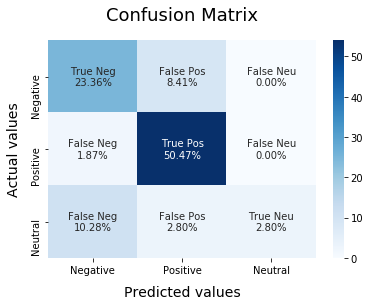

In [21]:
BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)

plt.show()

### <a name="p8-2">LinearSVC Model</a>

              precision    recall  f1-score   support

    negative       0.86      0.91      0.89        34
     neutral       1.00      0.95      0.97        56
    positive       0.83      0.88      0.86        17

    accuracy                           0.93       107
   macro avg       0.90      0.91      0.91       107
weighted avg       0.93      0.93      0.93       107



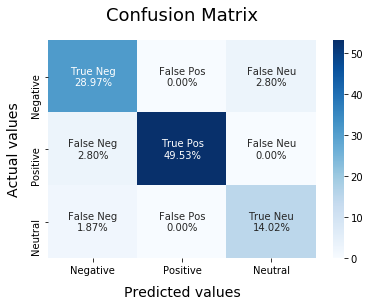

In [22]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)

### <a name="p8-3">Logistic Regression Model</a>

              precision    recall  f1-score   support

    negative       0.85      0.97      0.90        34
     neutral       1.00      0.95      0.97        56
    positive       0.93      0.82      0.87        17

    accuracy                           0.93       107
   macro avg       0.93      0.91      0.92       107
weighted avg       0.94      0.93      0.94       107



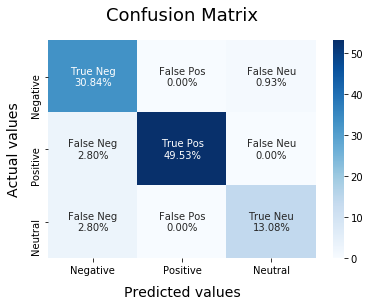

In [23]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)

## <a name="p9">Saving the Models</a>
We're using **PICKLE** to save **Vectoriser and BernoulliNB, Logistic Regression Model** for later use.

In [24]:
file = open('vectoriser-ngram-(1,2).pickle','wb')
pickle.dump(vectoriser, file)
file.close()

file = open('Sentiment-LR.pickle','wb')
pickle.dump(LRmodel, file)
file.close()

file = open('Sentiment-BNB.pickle','wb')
pickle.dump(BNBmodel, file)
file.close()

## <a name="p10">Using the Model.</a>

To use the model for **Sentiment Prediction** we need to import the **Vectoriser** and **LR Model** using **Pickle**.

The vectoriser can be used to transform data to matrix of TF-IDF Features.
While the model can be used to predict the sentiment of the transformed Data.
The text whose sentiment has to be predicted however must be preprocessed.

In [25]:
import pickle
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

def preprocess(text):
    return text

def train_and_save_models():

    vectoriser = TfidfVectorizer(ngram_range=(1, 2))
    X_train_transformed = vectoriser.fit_transform(X_train)

    LRmodel = LogisticRegression()
    LRmodel.fit(X_train_transformed, y_train)  

    with open('./vectoriser-ngram-(1,2).pickle', 'wb') as file:
        pickle.dump(vectoriser, file)

    with open('./Sentiment-LR.pickle', 'wb') as file:
        pickle.dump(LRmodel, file)

def load_models():
    file = open('./vectoriser-ngram-(1,2).pickle', 'rb')
    vectoriser = pickle.load(file)
    file.close()

    file = open('./Sentiment-LR.pickle', 'rb')
    LRmodel = pickle.load(file)
    file.close()

    return vectoriser, LRmodel

def predict(vectoriser, model, text):
    textdata = vectoriser.transform(preprocess(text))
    sentiment = model.predict(textdata)

    data = []
    for txt, pred in zip(text, sentiment):
        data.append((txt, pred))

    df = pd.DataFrame(data, columns=['text', 'sentiment'])
    df = df.replace([ 0, 1], ["Negative", "Positive"])
    return df

if __name__ == "__main__":
    vectoriser, LRmodel = load_models()

    text = ["Aku benci kamu",
            "semoga sehat-sehat saja",
            "antisipasi covid di sekitar",
            "maling di pasar"]

    df = predict(vectoriser, LRmodel, text)
    print(df.head())


                          text sentiment
0               Aku benci kamu  negative
1      semoga sehat-sehat saja  positive
2  antisipasi covid di sekitar  positive
3              maling di pasar  negative
